In [1]:
import gdown
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import os

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Data Analysis and Pre-Processing

In [2]:
file_id = '1xt7mcKk_AtughkHaNHwTckD7XedTilPF'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'data.csv'
gdown.download(url, output, quiet=False)

# Load CSV
df = pd.read_csv('data.csv')
print("Dataset Head:")
display(df.head())


Downloading...
From: https://drive.google.com/uc?id=1xt7mcKk_AtughkHaNHwTckD7XedTilPF
To: /content/data.csv
100%|██████████| 2.60M/2.60M [00:00<00:00, 22.2MB/s]


Dataset Head:


,Date,Time,Label,Temperature_F,PIR_1,PIR_2,PIR_3,PIR_4,PIR_5,PIR_6,...,PIR_46,PIR_47,PIR_48,PIR_49,PIR_50,PIR_51,PIR_52,PIR_53,PIR_54,PIR_55
0,2024-08-08,19:19:56,0,86,10269,10721,11156,11170,10931,10671,...,11178,11197,11161,11096,10957,10839,10735,10590,10411,10329
1,2024-08-08,19:20:12,1,86,10364,10907,11299,11238,10867,10535,...,11122,11145,11136,11108,11041,10824,10645,10493,10398,10357
2,2024-08-08,19:20:28,0,86,10329,10793,11197,11242,11052,10658,...,11168,11204,11162,11109,11007,10867,10700,10533,10427,10265
3,2024-08-08,19:20:44,0,86,10169,10425,10822,11133,11136,10834,...,11116,11273,11186,10984,10910,10807,10714,10651,10562,10463
4,2024-08-08,19:21:00,0,86,10320,10667,11104,11234,11129,10814,...,11006,11257,11370,11173,10924,10816,10754,10588,10428,10407


### Plot : Label Frequency Distribution

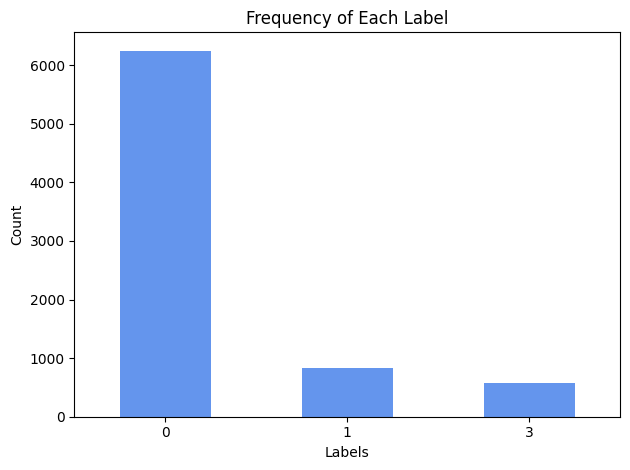

In [3]:
df['Label'].value_counts().plot(kind='bar', color='cornflowerblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Frequency of Each Label')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### In this example, we change Label 3 to Label 2.


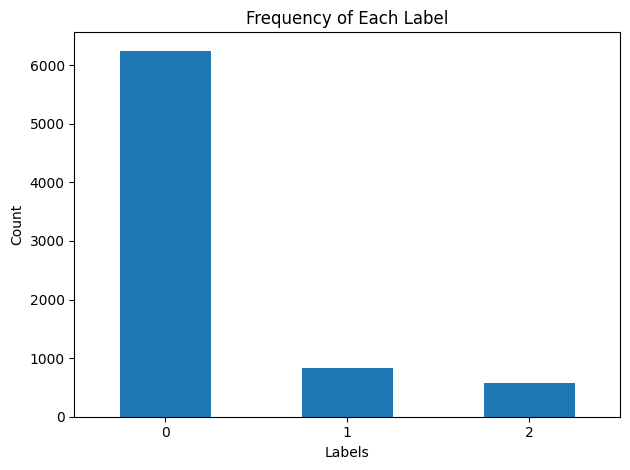

In [4]:
df.loc[df['Label'] == 3, 'Label'] = 2
df['Label'].value_counts().plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Frequency of Each Label')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [5]:
print(df['Temperature_F'].unique())

[86 87  0 88 89 85]


### Plot 2: Temperature Distribution
Visualize temperature count and also display what labels are present at each temperature.

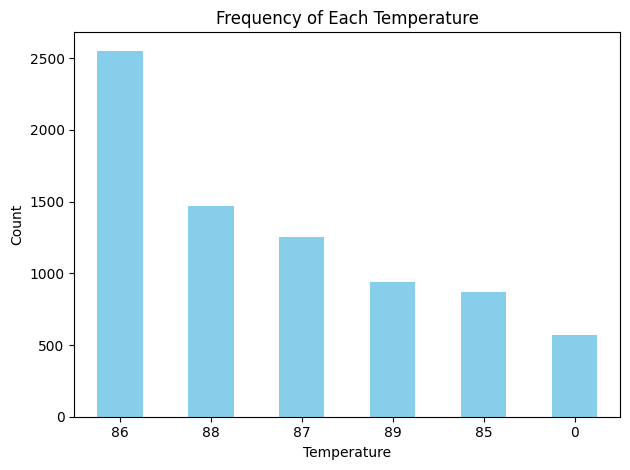

In [6]:
import matplotlib.pyplot as plt

# Plot value counts as a bar chart
df['Temperature_F'].value_counts().plot(kind='bar',color = 'skyblue')

# Add labels and title
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.title('Frequency of Each Temperature')
plt.xticks(rotation=0)  # rotate labels if needed
plt.tight_layout()       # avoid clipping
plt.show()

In [7]:
for temp in sorted(df['Temperature_F'].unique()):
    labels_present = df[df['Temperature_F'] == temp]['Label'].unique()
    print(f"Temperature: {temp}°F → Labels present: {labels_present}")


Temperature: 0°F → Labels present: [2]
Temperature: 85°F → Labels present: [0 1]
Temperature: 86°F → Labels present: [0 1]
Temperature: 87°F → Labels present: [0 1]
Temperature: 88°F → Labels present: [0]
Temperature: 89°F → Labels present: [0]


 ### Plot : Temperature vs. Label Distribution (Count Plot)

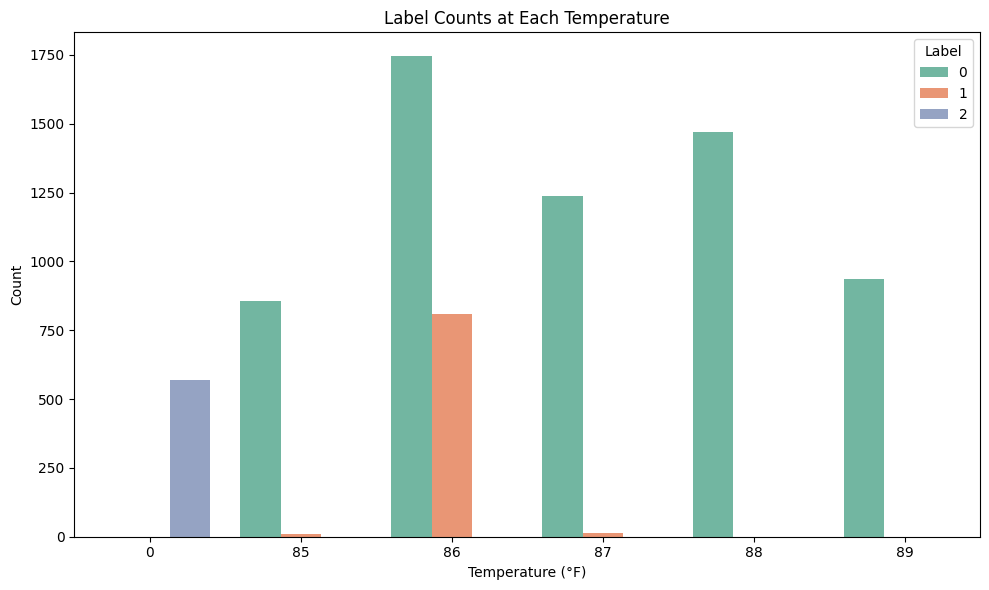

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Temperature_F', hue='Label', palette='Set2')
plt.title("Label Counts at Each Temperature")
plt.xlabel("Temperature (°F)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Label")
plt.tight_layout()
plt.show()

### Preprocessing Functions

- we parse the datetime features, split data into training and testing sets and (optionally) drop outliers.
- Next, we define a function for further data preprocessing.

In [9]:
# -----------------------------
#  Preprocessing Functions
# -----------------------------
def parse_datetime_features(df):
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['dayofweek'] = df['Date'].dt.dayofweek
        df.drop(columns=['Date'], inplace=True)
    if 'Time' in df.columns:
        df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
        df['hour'] = df['Time'].dt.hour
        df['minute'] = df['Time'].dt.minute
        df['second'] = df['Time'].dt.second
        df.drop(columns=['Time'], inplace=True)
    return df

def preprocess_data(df, test_size=0.2, random_state=42):
    df = parse_datetime_features(df)
    X = df.drop('Label', axis=1).select_dtypes(include=['number'])
    y = df['Label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    # Drop (Temperature_F == 0 & Label == 3) from train
    train_df = X_train.copy()
    train_df['Label'] = y_train
    initial = len(train_df)
    # train_df = train_df[~((train_df['Temperature_F'] == 0) & (train_df['Label'] == 3))]
    # print(f"Dropped {initial - len(train_df)} rows from training set.")
    X_train = train_df.drop('Label', axis=1)
    y_train = train_df['Label']
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(df)


def preprocess_test_data(df, test_size=0.2, random_state=42):
    df = parse_datetime_features(df)
    X = df.drop('Label', axis=1).select_dtypes(include=['number'])
    y = df['Label']
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=test_size, random_state=random_state, stratify=y
    # )
    # Drop (Temperature_F == 0 & Label == 3) from train
    train_df = X.copy()
    train_df['Label'] = y
    initial = len(train_df)
    # train_df = train_df[~((train_df['Temperature_F'] == 0) & (train_df['Label'] == 3))]
    # print(f"Dropped {initial - len(train_df)} rows from training set.")
    X_test = train_df.drop('Label', axis=1)
    y_test = train_df['Label']
    return X_test, y_test

In [10]:
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (6120, 63)
Testing set shape: (1531, 63)


 ### Additional Visualization: PIR Sensor Activation Patterns per Label
 Here, we plot the PIR sensor activation patterns for a subset of data for each label.


In [11]:

def plot_per_label_patterns(df, pir_columns):
    labels = sorted(df['Label'].unique())
    for label in labels:
        subset = df[df['Label'] == label][pir_columns].head(100)
        mean_pattern = subset.mean()

        print(f" Plotting PIR patterns for Label {label}")
        plt.figure(figsize=(14, 6))
        for i in range(len(subset)):
            plt.plot(range(1, 56), subset.iloc[i], alpha=0.3, color='gray')
        plt.plot(range(1, 56), mean_pattern, color='red', linewidth=2, label='Mean Pattern')
        plt.title(f"Label {label}: First 100 PIR Activation Patterns")
        plt.xlabel("Sensor Index (1–55)")
        plt.ylabel("PIR Activation")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

 Plotting PIR patterns for Label 0


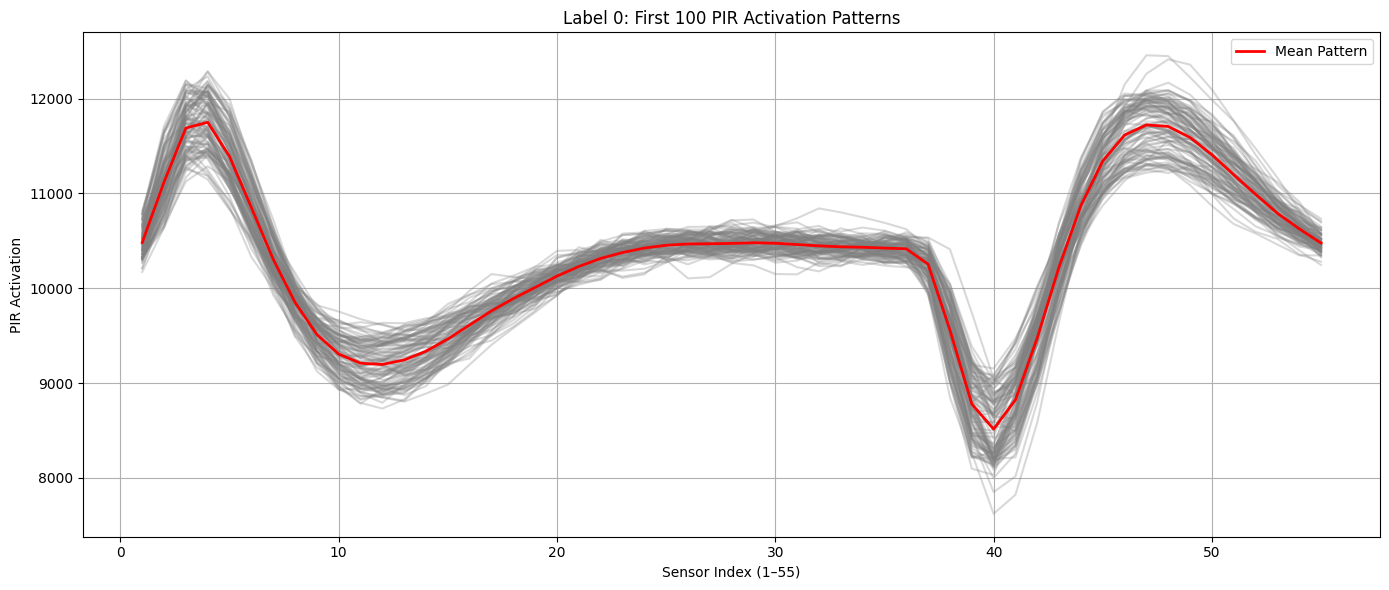

 Plotting PIR patterns for Label 1


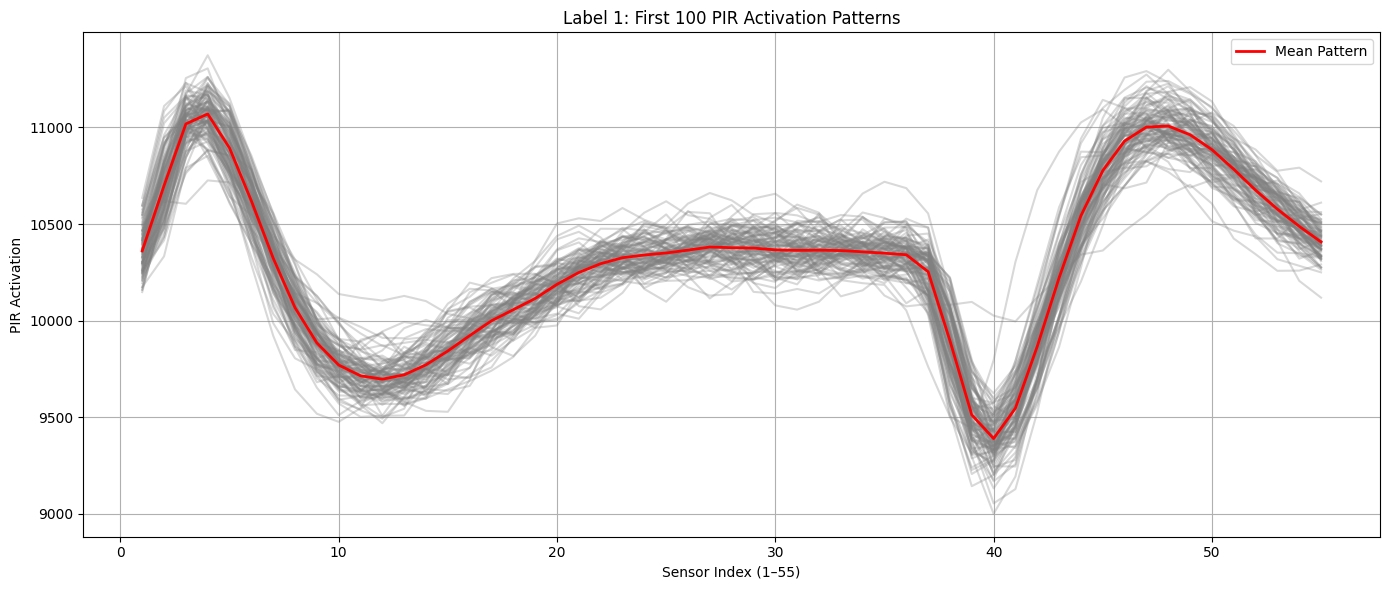

 Plotting PIR patterns for Label 2


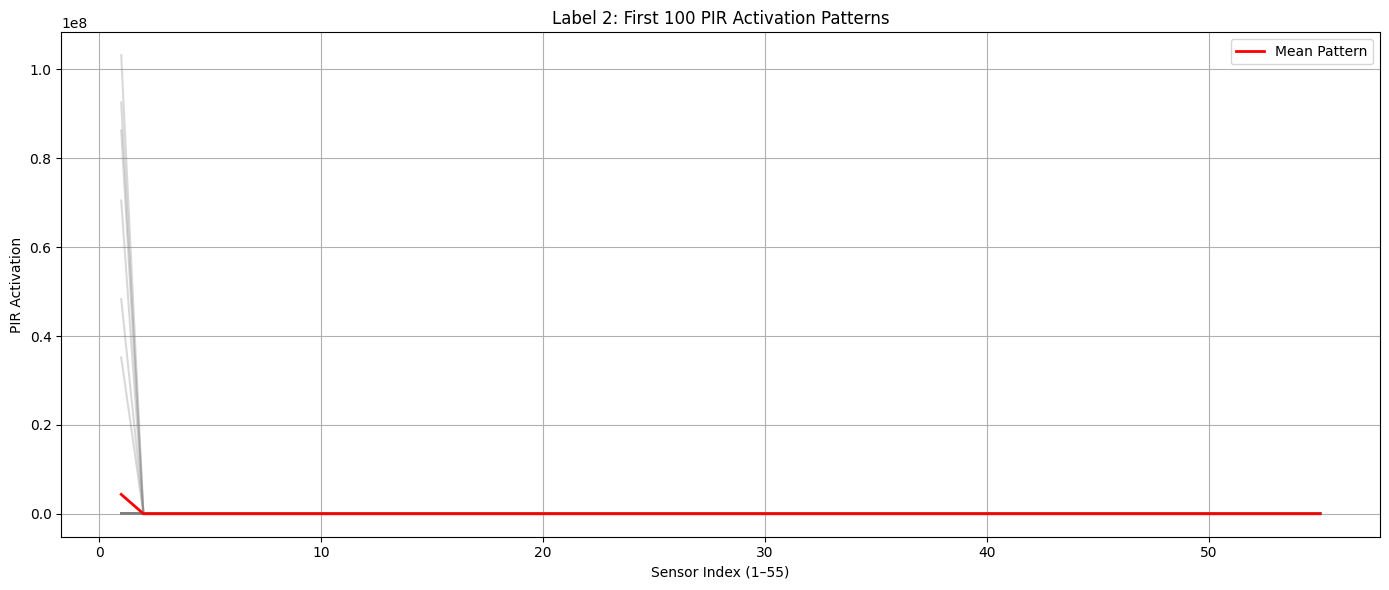

In [12]:

X_train, X_test, y_train, y_test = preprocess_data(df)

#  Get PIR columns
pir_columns = [col for col in df.columns if 'PIR' in col]

# Combine for plotting
train_df = X_train.copy()
train_df['Label'] = y_train

# Plot patterns
plot_per_label_patterns(train_df, pir_columns)


### Oversampling dataset

In [ ]:
# -----------------------------
# 3. SMOTE on Labels 0 & 1
# -----------------------------
# binary_mask = y_train.isin([0,1])



# -----------------------------
# 3. SMOTE on Labels 0 & 1 & 2
# -----------------------------
binary_mask = y_train.isin([0,1,2])
X_bin = X_train[binary_mask]; y_bin = y_train[binary_mask]
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_bin, y_bin)
print("After SMOTE:", pd.Series(y_res).value_counts())

# Reassemble training set
X_train = pd.DataFrame(X_res, columns=X_train.columns)
y_train = pd.Series(y_res)

# Split off validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)


After SMOTE: Label
0    4997
1    4997
2    4997
Name: count, dtype: int64


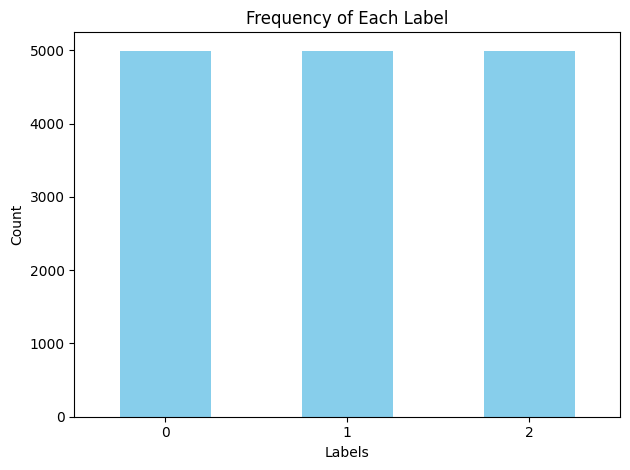

In [ ]:
import matplotlib.pyplot as plt

# Plot value counts as a bar chart
y_res.value_counts().plot(kind='bar',color = 'skyblue')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Frequency of Each Label')
plt.xticks(rotation=0)  # rotate labels if needed
plt.tight_layout()       # avoid clipping
plt.show()


In [ ]:
print("Training set after SMOTE:", X_train.shape)
print("Validation set shape:", X_val.shape)


Training set after SMOTE: (13491, 63)
Validation set shape: (1500, 63)


### Scaling & Tensor Preparation
- Scale all numeric features using StandardScaler and prepare PyTorch tensors.  
- We also extract the raw temperature values to be used later for overriding predictions where necessary.

In [ ]:
# -----------------------------
# 4. Scaling & Tensor Preparation
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Extract raw Temperature_F for override
temp_train_raw = X_train['Temperature_F'].values
temp_val_raw   = X_val['Temperature_F'].values
temp_test_raw  = X_test['Temperature_F'].values

# Convert to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values,   dtype=torch.long)
temp_train_t = torch.tensor(temp_train_raw, dtype=torch.float32)

X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
y_val_t   = torch.tensor(y_val.values,     dtype=torch.long)
temp_val_t   = torch.tensor(temp_val_raw,   dtype=torch.float32)

X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values,    dtype=torch.long)
temp_test_t  = torch.tensor(temp_test_raw,  dtype=torch.float32)

batch_size = 32
train_loader = DataLoader(
    TensorDataset(X_train_t, temp_train_t, y_train_t),
    batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(X_val_t, temp_val_t, y_val_t),
    batch_size=batch_size
)
test_loader = DataLoader(
    TensorDataset(X_test_t, temp_test_t, y_test_t),
    batch_size=batch_size
)

# Applying MLP model

### Define the MLP Model

- This is a basic feed-forward network with dropout and batch normalization layers.


In [ ]:
# -----------------------------
# 5. Define Model
# -----------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.4),
            nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(0.3),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
num_classes = len(y_train.unique())
model = MLP(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=3, bias=True)
  )
)


 ### Train the MLP Model with Early Stopping & Plot Training Curves

 We track training loss and validation accuracy over epochs. Predictions are overridden for samples with temperature 0.


In [ ]:
best_acc = 0.0
best_wts = copy.deepcopy(model.state_dict())
patience, counter = 7, 0
epochs = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = total = 0

    for xb, temp_raw, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Accuracy during training
        _, preds = torch.max(out, 1)
        idx = torch.where(temp_raw == 0)[0]
        if idx.numel():
            preds[idx] = 2
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = val_total = 0

    with torch.no_grad():
        for xb, temp_raw, yb in val_loader:  # <-- Correct loader here
            out = model(xb)
            loss = criterion(out, yb)
            val_running_loss += loss.item()
            _, preds = torch.max(out, 1)
            idx = torch.where(temp_raw == 0)[0]
            if idx.numel():
                preds[idx] = 2
            val_correct += (preds == yb).sum().item()
            val_total += yb.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_acc)
    print(f"Epoch {epoch+1:02d}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    # Early stopping
    if val_acc > best_acc:
        best_acc = val_acc
        best_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model weights
model.load_state_dict(best_wts)


Epoch 01: Train Loss = 0.1243, Train Acc = 0.9698, Val Loss = 0.0229, Val Acc = 0.9933
Epoch 02: Train Loss = 0.0486, Train Acc = 0.9858, Val Loss = 0.0187, Val Acc = 0.9973
Epoch 03: Train Loss = 0.0375, Train Acc = 0.9891, Val Loss = 0.0191, Val Acc = 0.9967
Epoch 04: Train Loss = 0.0339, Train Acc = 0.9898, Val Loss = 0.0156, Val Acc = 0.9967
Epoch 05: Train Loss = 0.0317, Train Acc = 0.9903, Val Loss = 0.0178, Val Acc = 0.9967
Epoch 06: Train Loss = 0.0311, Train Acc = 0.9907, Val Loss = 0.0144, Val Acc = 0.9947
Epoch 07: Train Loss = 0.0242, Train Acc = 0.9920, Val Loss = 0.0147, Val Acc = 0.9947
Epoch 08: Train Loss = 0.0271, Train Acc = 0.9918, Val Loss = 0.0150, Val Acc = 0.9953
Epoch 09: Train Loss = 0.0234, Train Acc = 0.9924, Val Loss = 0.0159, Val Acc = 0.9927
Early stopping triggered.


<All keys matched successfully>

### Plot: Training Loss & Validation Accuracy Curves

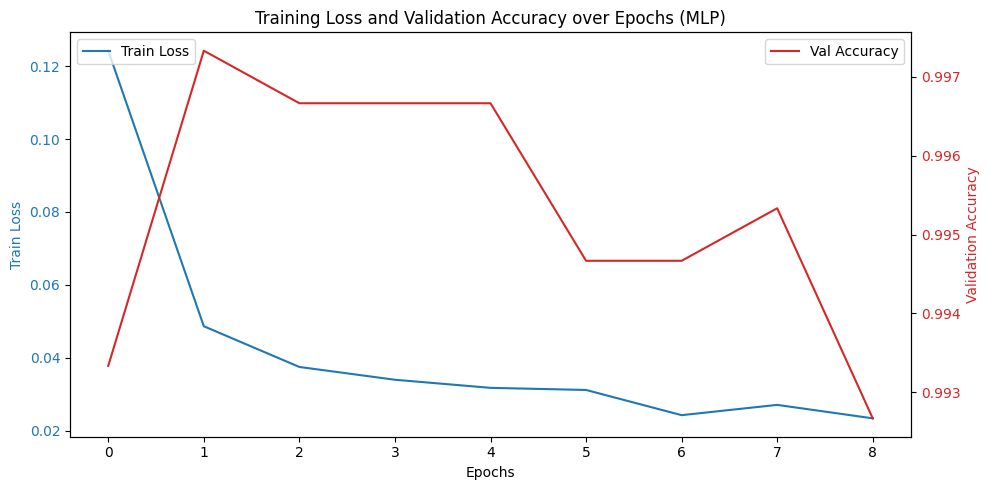

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(train_losses, color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Validation Accuracy', color=color)
ax2.plot(val_accuracies, color=color, label='Val Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title("Training Loss and Validation Accuracy over Epochs (MLP)")
plt.tight_layout()
plt.show()


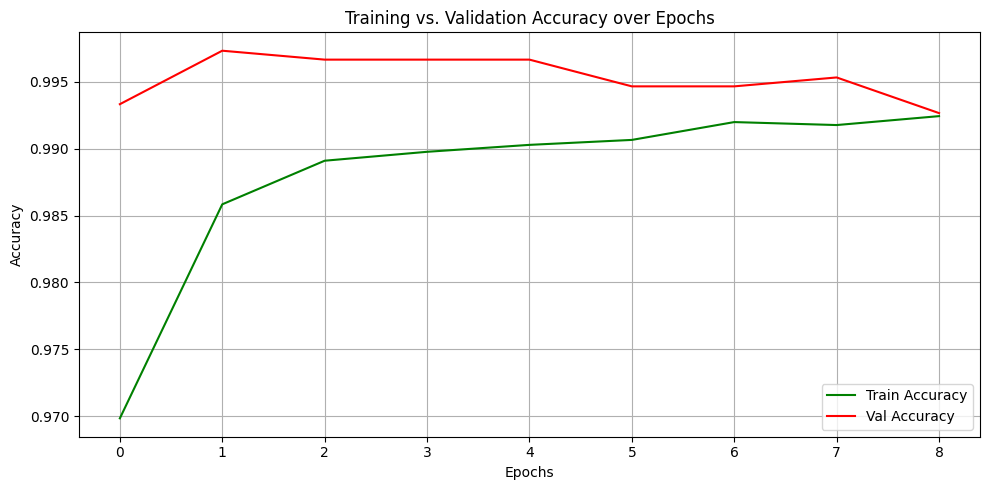

In [ ]:
# Plot: Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Val Accuracy', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


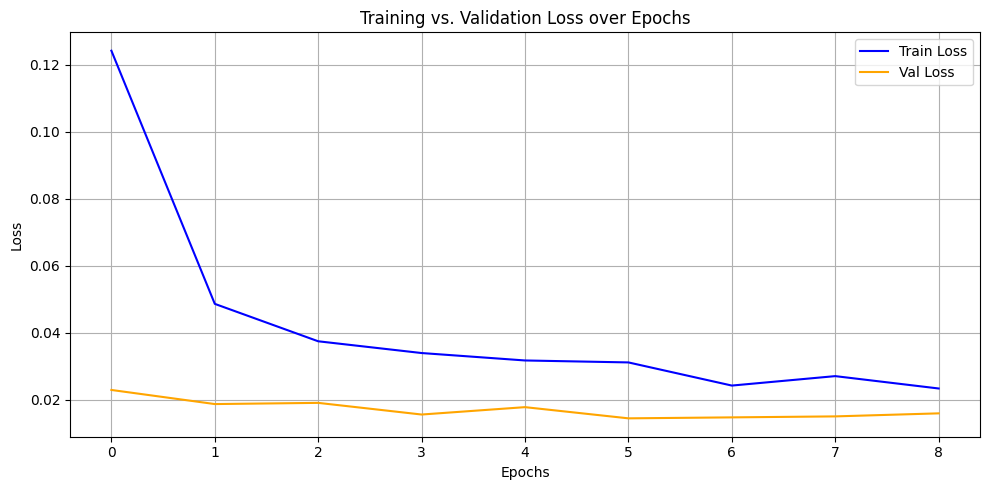

In [ ]:
# Plot: Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 ### Evaluate the MLP Model on Test Data

We compute the test accuracy, confusion matrix and detailed classification report (including macro F1).



MLP Test Accuracy: 0.9902
MLP Macro F1-Score: 0.9836



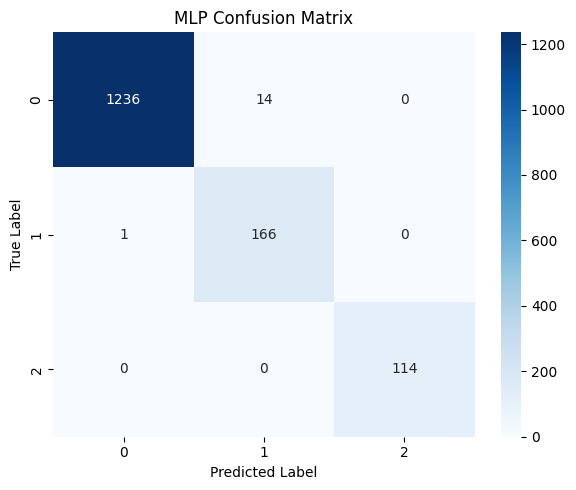


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1250
           1       0.92      0.99      0.96       167
           2       1.00      1.00      1.00       114

    accuracy                           0.99      1531
   macro avg       0.97      0.99      0.98      1531
weighted avg       0.99      0.99      0.99      1531



In [ ]:
# -----------------------------
# 7. Test & Report
# -----------------------------
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, temp_raw, yb in test_loader:
        out = model(xb)
        _, preds = torch.max(out, 1)
        # Override predictions where temperature equals 0 if desired:
        idx = torch.where(temp_raw == 0)[0]
        if idx.numel():
            preds[idx] = 2
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
test_acc = (all_preds == all_labels).mean()
macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f"\nMLP Test Accuracy: {test_acc:.4f}")
print(f"MLP Macro F1-Score: {macro_f1:.4f}\n")

# Confusion Matrix Plot
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("MLP Confusion Matrix")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, labels=[0,1,2]))


### 5-Fold Cross Validation for MLP Model

We perform stratified 5-fold cross validation and print for each fold:
- Best accuracy
- Macro F1 scores and detailed classification metrics per fold.

The best performing model is saved as a checkpoint.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def train_and_validate_mlp_best_only(X, y, raw_temp, num_classes, checkpoint_path='team_6_checkpoints/team_6_mlp.pt'):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

    best_acc_overall = 0.0
    best_model_wts = None
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n=== MLP Fold {fold+1} ===")
        X_train_f, X_val_f = X[train_idx], X[val_idx]
        y_train_f, y_val_f = y[train_idx], y[val_idx]
        temp_train_f, temp_val_f = raw_temp[train_idx], raw_temp[val_idx]

        train_loader_f = DataLoader(TensorDataset(X_train_f, temp_train_f, y_train_f), batch_size=32, shuffle=True)
        val_loader_f = DataLoader(TensorDataset(X_val_f, temp_val_f, y_val_f), batch_size=32)

        model_f = MLP(input_dim=X.shape[1], num_classes=num_classes)
        criterion_f = nn.CrossEntropyLoss()
        optimizer_f = optim.Adam(model_f.parameters(), lr=1e-3)
        scheduler_f = ReduceLROnPlateau(optimizer_f, mode='max', factor=0.5, patience=3)

        best_acc_fold = 0.0
        best_fold_wts = copy.deepcopy(model_f.state_dict())
        counter, patience = 0, 7

        all_fold_preds = []
        all_fold_labels = []

        for epoch in range(50):
            model_f.train()
            for xb, temp_raw, yb in train_loader_f:
                optimizer_f.zero_grad()
                out = model_f(xb)
                loss = criterion_f(out, yb)
                loss.backward()
                optimizer_f.step()

            # Evaluate on validation fold
            model_f.eval()
            correct = total = 0
            all_fold_preds.clear()
            all_fold_labels.clear()
            with torch.no_grad():
                for xb, temp_raw, yb in val_loader_f:
                    out = model_f(xb)
                    _, preds = torch.max(out, 1)
                    idx = torch.where(temp_raw == 0)[0]
                    if idx.numel():
                        preds[idx] = 2
                    correct += (preds == yb).sum().item()
                    total += yb.size(0)
                    all_fold_preds.extend(preds.cpu().numpy())
                    all_fold_labels.extend(yb.cpu().numpy())

            val_acc = correct / total
            scheduler_f.step(val_acc)
            print(f"Epoch {epoch+1:02d} - Val Acc: {val_acc:.4f}")

            if val_acc > best_acc_fold:
                best_acc_fold = val_acc
                best_fold_wts = copy.deepcopy(model_f.state_dict())
                best_preds_fold = all_fold_preds.copy()
                best_labels_fold = all_fold_labels.copy()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping on this fold.")
                    break

        # Metrics for this fold
        macro_f1_fold = f1_score(best_labels_fold, best_preds_fold, average='macro')
        print(f"Fold {fold+1} - Best Val Accuracy: {best_acc_fold:.4f}, Macro F1: {macro_f1_fold:.4f}")
        print("\nClassification Report:")
        print(classification_report(best_labels_fold, best_preds_fold, digits=4))

        cm = confusion_matrix(best_labels_fold, best_preds_fold)
        cm_df = pd.DataFrame(cm, index=[f"True_{i}" for i in range(num_classes)],
                                columns=[f"Pred_{i}" for i in range(num_classes)])
        print("\nConfusion Matrix:")
        print(cm_df)

        # Optional: Save confusion matrix as plot
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold+1}')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig(f'team_6_checkpoints/mlp_confusion_fold_{fold+1}.png')
        plt.close()

        fold_metrics.append((best_acc_fold, macro_f1_fold))

        if best_acc_fold > best_acc_overall:
            best_acc_overall = best_acc_fold
            best_model_wts = best_fold_wts

    torch.save(best_model_wts, checkpoint_path)
    print(f"\nBest overall MLP model saved to: {checkpoint_path} with Val Acc: {best_acc_overall:.4f}")
    return fold_metrics


In [ ]:
X_comb = torch.tensor(X_train_scaled, dtype=torch.float32)
y_comb = torch.tensor(y_train.values, dtype=torch.long)
temp_comb = torch.tensor(temp_train_raw, dtype=torch.float32)

fold_results = train_and_validate_mlp_best_only(X_comb, y_comb, temp_comb, num_classes=num_classes)
print("Fold-wise Metrics (Accuracy, Macro F1):", fold_results)



=== MLP Fold 1 ===
Epoch 01 - Val Acc: 0.9956
Epoch 02 - Val Acc: 0.9941
Epoch 03 - Val Acc: 0.9952
Epoch 04 - Val Acc: 0.9922
Epoch 05 - Val Acc: 0.9952
Epoch 06 - Val Acc: 0.9948
Epoch 07 - Val Acc: 0.9952
Epoch 08 - Val Acc: 0.9959
Epoch 09 - Val Acc: 0.9956
Epoch 10 - Val Acc: 0.9944
Epoch 11 - Val Acc: 0.9952
Epoch 12 - Val Acc: 0.9963
Epoch 13 - Val Acc: 0.9941
Epoch 14 - Val Acc: 0.9981
Epoch 15 - Val Acc: 0.9967
Epoch 16 - Val Acc: 0.9970
Epoch 17 - Val Acc: 0.9959
Epoch 18 - Val Acc: 0.9952
Epoch 19 - Val Acc: 0.9959
Epoch 20 - Val Acc: 0.9970
Epoch 21 - Val Acc: 0.9970
Early stopping on this fold.
Fold 1 - Best Val Accuracy: 0.9981, Macro F1: 0.9981

Classification Report:
              precision    recall  f1-score   support

           0     0.9956    0.9989    0.9972       900
           1     0.9989    0.9956    0.9972       900
           2     1.0000    1.0000    1.0000       899

    accuracy                         0.9981      2699
   macro avg     0.9982    0.9981  

In [ ]:
from sklearn.metrics import classification_report


def evaluate_mlp(checkpoint_path, X_test, y_test, temp_test_raw, input_dim, num_classes):
    model = MLP(input_dim=input_dim, num_classes=num_classes)
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    test_loader = DataLoader(TensorDataset(X_test, temp_test_raw, y_test), batch_size=32)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, temp_raw, yb in test_loader:
            out = model(xb)
            _, preds = torch.max(out, 1)
            idx = torch.where(temp_raw == 0)[0]
            if idx.numel(): preds[idx] = 2
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    acc = (np.array(all_preds) == np.array(all_labels)).mean()
    print(f"\nTest Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds, labels=[0,1,2]))
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, labels=[0,1,2],zero_division=0))


In [ ]:
# Prepare combined tensors for 5-fold CV
X_comb = torch.tensor(X_train_scaled, dtype=torch.float32)
y_comb = torch.tensor(y_train.values, dtype=torch.long)
temp_comb = torch.tensor(temp_train_raw, dtype=torch.float32)

# train_and_validate_mlp_best_only(X_comb, y_comb, temp_comb, num_classes=num_classes)

# Evaluate a specific fold model (e.g., fold 0)
evaluate_mlp(
    checkpoint_path="team_6_checkpoints/team_6_mlp.pt",
    X_test=X_test_t,
    y_test=y_test_t,
    temp_test_raw=temp_test_t,
    input_dim=input_dim,
    num_classes=num_classes
)



Test Accuracy: 0.9954
Confusion Matrix:
 [[1246    4    0]
 [   3  164    0]
 [   0    0  114]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1250
           1       0.98      0.98      0.98       167
           2       1.00      1.00      1.00       114

    accuracy                           1.00      1531
   macro avg       0.99      0.99      0.99      1531
weighted avg       1.00      1.00      1.00      1531



# LSTM Model Implementation
The LSTM model uses only the PIR sensor readings (55 values) plus raw temperature.
The PIR sensor data is reshaped to be a sequence and the temperature is repeated per time step.



In [ ]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])  # use output at last timestep


 ### Prepare LSTM Input Tensors

 We extract only the PIR sensor columns. For each sample, the PIR data (55 values) is reshaped into a sequence and the corresponding temperature is repeated across the sequence length. ### Prepare LSTM Input Tensors

We extract only the PIR sensor columns. For each sample, the PIR data (55 values) is reshaped into a sequence and the corresponding temperature is repeated across the sequence length.The final shape becomes (N, 55, 2).


In [ ]:
import joblib
import pickle
from sklearn.preprocessing import StandardScaler

# For the LSTM we use only the PIR sensor columns.
# Extract PIR sensor columns for train and test:
X_train_pir = X_train[pir_columns].values    # shape should be (N, 55)
X_test_pir  = X_test[pir_columns].values

# Scale the PIR data separately
scaler_pir = StandardScaler()
X_train_pir_scaled = scaler_pir.fit_transform(X_train_pir)
X_test_pir_scaled  = scaler_pir.transform(X_test_pir)

# Save the fitted scaler to a file
with open("team_6_scaler_pir.pkl", "wb") as f:
    pickle.dump(scaler_pir, f)



def prepare_lstm_input_tensor(X_np, temp_np):
    """
    X_np: (N, 55) numpy array for PIR sensors
    temp_np: (N,) numpy array of Temperature_F
    Returns: torch tensor of shape (N, 55, 2)
    """
    pir_seq = X_np.reshape(-1, 55, 1)  # reshape to (N, 55, 1)
    # Repeat each temperature value 55 times along axis 1:
    temp_seq = np.repeat(temp_np.reshape(-1, 1, 1), repeats=55, axis=1)  # shape: (N, 55, 1)
    combined = np.concatenate([pir_seq, temp_seq], axis=2)  # shape becomes (N, 55, 2)
    return torch.tensor(combined, dtype=torch.float32)


# Prepare LSTM tensors for training and testing
# Use the corresponding Temperature_F values (raw)
X_comb_lstm = prepare_lstm_input_tensor(X_train_pir_scaled, temp_train_raw)
X_test_seq = prepare_lstm_input_tensor(X_test_pir_scaled, temp_test_raw)

# For cross-validation with LSTM, also convert y and temp for training
y_comb_lstm = torch.tensor(y_train.values, dtype=torch.long)
temp_comb_lstm = torch.tensor(temp_train_raw, dtype=torch.float32)

### Train and Validate the LSTM Model with 5-Fold Cross Validation
The training procedure is similar to the MLP. In this LSTM example we do not override predictions using temperature.

In [ ]:
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix

def train_and_validate_lstm_best_only(X_seq, y, raw_temp, num_classes, checkpoint_path='team_6_checkpoints/team_6_lstm.pt'):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

    best_acc_overall = 0.0
    best_model_wts = None


    all_fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_seq, y)):
        all_train_losses = []
        all_val_losses = []
        all_train_accuracies = []
        all_val_accuracies = []


        print(f"\n=== LSTM Fold {fold+1} ===")
        X_train_f, X_val_f = X_seq[train_idx], X_seq[val_idx]
        y_train_f, y_val_f = y[train_idx], y[val_idx]
        temp_train_f, temp_val_f = raw_temp[train_idx], raw_temp[val_idx]

        train_loader = DataLoader(TensorDataset(X_train_f, temp_train_f, y_train_f), batch_size=32, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_f, temp_val_f, y_val_f), batch_size=32)

        input_size = X_seq.shape[2]
        model = LSTMModel(input_size=input_size, hidden_size=64, num_layers=1, num_classes=num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

        best_acc_fold = 0.0
        best_fold_wts = copy.deepcopy(model.state_dict())
        counter, patience = 0, 7

        for epoch in range(50):
            model.train()
            running_loss = 0.0
            correct = total = 0
            for xb, temp_raw, yb in train_loader:
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                _, preds = torch.max(out, 1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

            train_loss = running_loss / len(train_loader)
            train_acc = correct / total

            model.eval()
            val_running_loss = 0.0
            val_correct = val_total = 0
            all_val_preds = []
            all_val_labels = []

            with torch.no_grad():
                for xb, temp_raw, yb in val_loader:
                    out = model(xb)
                    loss = criterion(out, yb)
                    val_running_loss += loss.item()

                    _, preds = torch.max(out, 1)

                    # Rule: override prediction for temp == 0
                    idx = torch.where(temp_raw == 0)[0]
                    if idx.numel():
                        preds[idx] = 2

                    val_correct += (preds == yb).sum().item()
                    val_total += yb.size(0)

                    all_val_preds.extend(preds.cpu().numpy())
                    all_val_labels.extend(yb.cpu().numpy())

            val_loss = val_running_loss / len(val_loader)
            val_acc = val_correct / val_total
            scheduler.step(val_acc)
            all_train_losses.append(train_loss)
            all_val_losses.append(val_loss)
            all_train_accuracies.append(train_acc)
            all_val_accuracies.append(val_acc)

            print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            if val_acc > best_acc_fold:
                best_acc_fold = val_acc
                best_fold_wts = copy.deepcopy(model.state_dict())
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping.")
                    break

        print(f"Fold {fold+1} Best Val Acc: {best_acc_fold:.4f}")

        # =========================
        # Compute Evaluation Metrics
        # =========================
        macro_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
        precision, recall, f1_per_class, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average=None, zero_division=0)
        cm = confusion_matrix(all_val_labels, all_val_preds)

        print(f"Fold {fold+1} - Macro F1 Score: {macro_f1:.4f}")
        print(f"Class-wise Precision: {precision}")
        print(f"Class-wise Recall:    {recall}")
        print(f"Class-wise F1 Score:  {f1_per_class}")
        print(f"Confusion Matrix:\n{cm}")

        all_fold_metrics.append({
            "fold": fold + 1,
            "val_acc": best_acc_fold,
            "macro_f1": macro_f1,
            "precision": precision,
            "recall": recall,
            "f1": f1_per_class,
            "confusion_matrix": cm
        })

        if best_acc_fold > best_acc_overall:
            best_acc_overall = best_acc_fold
            best_model_wts = best_fold_wts

    torch.save(best_model_wts, checkpoint_path)
    print(f"\nBest LSTM model saved to: {checkpoint_path} with Val Acc: {best_acc_overall:.4f}")

    return {
        "train_losses": all_train_losses,
        "val_losses": all_val_losses,
        "train_accuracies": all_train_accuracies,
        "val_accuracies": all_val_accuracies,
        "fold_metrics": all_fold_metrics
    }



=== LSTM Fold 1 ===
Epoch 1 - Train Loss: 0.5150, Train Acc: 0.6639, Val Loss: 0.4658, Val Acc: 0.6665
Epoch 2 - Train Loss: 0.4527, Train Acc: 0.7248, Val Loss: 0.4300, Val Acc: 0.9396
Epoch 3 - Train Loss: 0.2228, Train Acc: 0.9228, Val Loss: 0.0705, Val Acc: 0.9804
Epoch 4 - Train Loss: 0.0686, Train Acc: 0.9783, Val Loss: 0.0745, Val Acc: 0.9796
Epoch 5 - Train Loss: 0.0549, Train Acc: 0.9830, Val Loss: 0.0602, Val Acc: 0.9885
Epoch 6 - Train Loss: 0.0489, Train Acc: 0.9842, Val Loss: 0.0324, Val Acc: 0.9893
Epoch 7 - Train Loss: 0.0562, Train Acc: 0.9819, Val Loss: 0.0637, Val Acc: 0.9748
Epoch 8 - Train Loss: 0.0523, Train Acc: 0.9827, Val Loss: 0.0359, Val Acc: 0.9896
Epoch 9 - Train Loss: 0.0489, Train Acc: 0.9848, Val Loss: 0.0363, Val Acc: 0.9889
Epoch 10 - Train Loss: 0.0461, Train Acc: 0.9852, Val Loss: 0.0326, Val Acc: 0.9874
Epoch 11 - Train Loss: 0.0440, Train Acc: 0.9852, Val Loss: 0.0338, Val Acc: 0.9874
Epoch 12 - Train Loss: 0.0397, Train Acc: 0.9867, Val Loss: 0.06

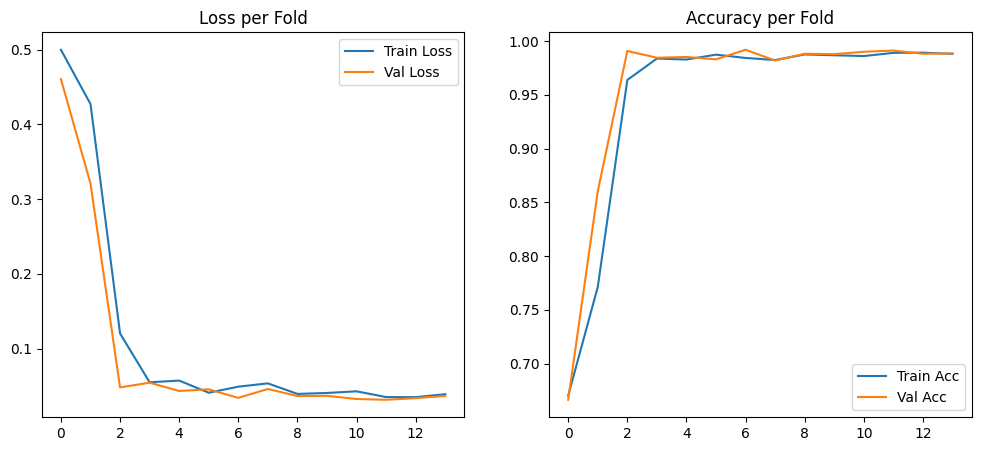

In [ ]:


metrics = train_and_validate_lstm_best_only(X_comb_lstm, y_comb_lstm, temp_comb_lstm, num_classes=num_classes)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(metrics['train_losses'], label='Train Loss')
plt.plot(metrics['val_losses'], label='Val Loss')
plt.title('Loss per Fold')
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics['train_accuracies'], label='Train Acc')
plt.plot(metrics['val_accuracies'], label='Val Acc')
plt.title('Accuracy per Fold')
plt.legend()

plt.show()


 ### Evaluate the LSTM Model on Test Data

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

def evaluate_lstm(checkpoint_path, X_test_seq, y_test, temp_test_raw, num_classes):
    input_size = X_test_seq.shape[2]
    model_lstm = LSTMModel(input_size=input_size, hidden_size=64, num_layers=1, num_classes=num_classes)
    model_lstm.load_state_dict(torch.load(checkpoint_path))
    model_lstm.eval()

    test_loader = DataLoader(TensorDataset(X_test_seq, temp_test_raw, y_test), batch_size=32)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, temp_raw, yb in test_loader:
            out = model_lstm(xb)
            _, preds = torch.max(out, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    acc = (all_preds == all_labels).mean()
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"\nLSTM Test Accuracy: {acc:.4f}")
    print(f"LSTM Macro F1-Score: {macro_f1:.4f}\n")

    cm_lstm = confusion_matrix(all_labels, all_preds, labels=[0,1,2])
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_lstm, annot=True, cmap='Oranges', fmt='d', xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title("LSTM Confusion Matrix")
    plt.tight_layout()
    plt.show()

    print("\nLSTM Classification Report:")
    print(classification_report(all_labels, all_preds, labels=[0,1,2]))

In [ ]:
X_test_t

tensor([[ 0.7686, -0.1280,  0.6858,  ..., -1.3489,  1.6637, -0.3644],
        [ 0.7686, -0.1280,  0.9065,  ..., -1.7199,  0.2678,  1.1745],
        [ 0.7196, -0.1280,  0.3362,  ...,  1.4331, -1.8592, -0.4926],
        ...,
        [ 0.7196, -0.1280,  1.1829,  ...,  1.6186,  0.2013,  1.4309],
        [ 0.7441, -0.1280,  0.6301,  ..., -2.0908,  1.3313,  1.0462],
        [ 0.6705, -0.1280,  0.1202,  ..., -1.1635,  1.3978, -0.3003]])

In [ ]:
X_train_scaled


array([[ 7.19584205e-01, -1.28011093e-01,  7.45030432e-01, ...,
        -2.27630460e+00,  4.00753562e-01,  1.49506855e+00],
       [-1.41390393e+00, -1.28019173e-01, -1.64287814e-01, ...,
         1.34824607e-01,  1.06545718e+00, -4.38063969e-02],
       [-1.41390393e+00, -1.28029272e-01, -1.42222620e-01, ...,
         1.34824607e-01,  5.33694286e-01, -5.56764714e-01],
       ...,
       [ 6.70538500e-01, -1.28018163e-01, -2.60900219e-02, ...,
        -9.78004257e-01, -1.65982766e+00,  1.23858939e+00],
       [-1.41390393e+00, -1.28014830e-01, -2.95739999e-02, ...,
         1.34824607e-01,  4.00753562e-01,  1.48552972e-01],
       [-1.41390393e+00, -1.27999479e-01, -3.65197209e-01, ...,
         1.34824607e-01,  1.93138996e-03,  8.44331823e-02]])


LSTM Test Accuracy: 0.9850
LSTM Macro F1-Score: 0.9749



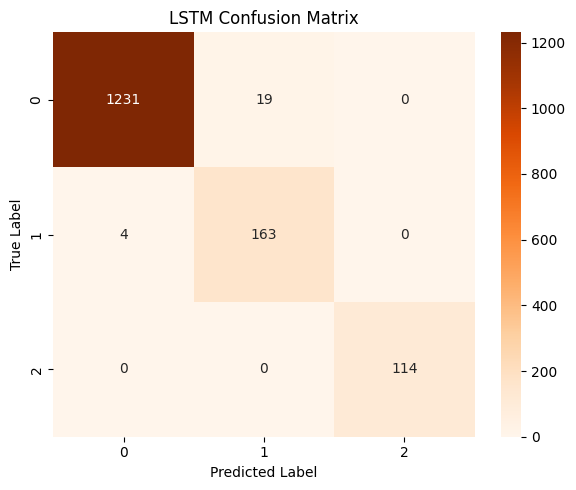


LSTM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1250
           1       0.90      0.98      0.93       167
           2       1.00      1.00      1.00       114

    accuracy                           0.98      1531
   macro avg       0.96      0.99      0.97      1531
weighted avg       0.99      0.98      0.99      1531



In [ ]:
evaluate_lstm(
    checkpoint_path="team_6_checkpoints/team_6_lstm.pt",
    X_test_seq=X_test_seq,
    y_test=y_test_t,          # y_test_t remains unchanged
    temp_test_raw=temp_test_t,
    num_classes=num_classes
)

# Final Evaluate function

In [ ]:
import gdown
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import os

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pickle


def preprocess_test_data(df, test_size=0.2, random_state=42):
    df = parse_datetime_features(df)
    X = df.drop('Label', axis=1).select_dtypes(include=['number'])
    y = df['Label']
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=test_size, random_state=random_state, stratify=y
    # )
    # Drop (Temperature_F == 0 & Label == 3) from train
    train_df = X.copy()
    train_df['Label'] = y
    initial = len(train_df)
    # train_df = train_df[~((train_df['Temperature_F'] == 0) & (train_df['Label'] == 3))]
    # print(f"Dropped {initial - len(train_df)} rows from training set.")
    X_test = train_df.drop('Label', axis=1)
    y_test = train_df['Label']
    return X_test, y_test


def prepare_lstm_input_tensor(X_np, temp_np):
    """
    X_np: (N, 55) numpy array for PIR sensors
    temp_np: (N,) numpy array of Temperature_F
    Returns: torch tensor of shape (N, 55, 2)
    """
    pir_seq = X_np.reshape(-1, 55, 1)  # reshape to (N, 55, 1)
    # Repeat each temperature value 55 times along axis 1:
    temp_seq = np.repeat(temp_np.reshape(-1, 1, 1), repeats=55, axis=1)  # shape: (N, 55, 1)
    combined = np.concatenate([pir_seq, temp_seq], axis=2)  # shape becomes (N, 55, 2)
    return torch.tensor(combined, dtype=torch.float32)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])  # use output at last timestep


def evaluate_model(datafile_path, checkpoint_path):
    # Evaluate a saved LSTM model on data from a CSV file.

    # Load the CSV file
    df = pd.read_csv(datafile_path)

    # Remap label 3 → 2 consistently
    if 'label' in df.columns:
        df['label'] = df['label'].replace(3, 2)

    # Preprocess (uses your logic)
    X_test, y_test = preprocess_test_data(df)

    # Extract PIR sensor data
    pir_columns = [col for col in X_test.columns if col.startswith('PIR_')]
    X_test_pir = X_test[pir_columns].values

    # Extract raw temperature
    temp_test_raw = X_test['Temperature_F'].values

    with open("team_6_scaler_pir.pkl", "rb") as f:
        scaler_pir = pickle.load(f)

    # Scale PIR sensor data using the same scaler from training
    X_test_pir_scaled = scaler_pir.transform(X_test_pir)

    # Prepare LSTM input tensors
    X_test_lstm = prepare_lstm_input_tensor(X_test_pir_scaled, temp_test_raw)
    y_test_tensor = torch.tensor(y_test.replace(3, 2).values, dtype=torch.long)  # Redundant check here too
    temp_test_tensor = torch.tensor(temp_test_raw, dtype=torch.float32).unsqueeze(1)

    # Evaluate using the model and return accuracy
    input_size = X_test_lstm.shape[2]
    num_classes = len(np.unique(y_test_tensor.numpy()))  # Dynamically determine from test labels
    model = LSTMModel(input_size=input_size, hidden_size=64, num_layers=1, num_classes=num_classes)
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    test_loader = DataLoader(TensorDataset(X_test_lstm, temp_test_tensor, y_test_tensor), batch_size=32)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, temp_raw, yb in test_loader:
            out = model(xb)
            _, preds = torch.max(out, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    acc = (all_preds == all_labels).mean()

    print(f"\nEvaluation complete.")
    return acc


In [ ]:
acc = evaluate_model("data.csv", "team_6_checkpoints/team_6_lstm.pt")
print(f"Returned Accuracy: {acc:.4f}")



Evaluation complete.
Returned Accuracy: 0.9838
